In [21]:
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud
from langdetect import detect
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords

In [22]:
# Carica il dataset
file_path = 'input/output.csv'
data = pd.read_csv(file_path)

data = data.dropna(subset=['content'])
print("Numero di righe prima del filtro:", len(data))
def preprocess_text(text):
    """Preprocessing del testo"""
    if pd.isna(text):
        return ""
    
    # Converte in minuscolo
    text = text.lower()
    
    # Rimuove URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Mantiene solo lettere, numeri, spazi e alcuni simboli
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Rimuove spazi multipli
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

data['processed_content'] = data['content'].apply(preprocess_text)
print("Numero di righe dopo il filtro:", len(data))

print("Distribuzione delle classi:\n", data['is_positive'].value_counts())

Numero di righe prima del filtro: 200723
Numero di righe dopo il filtro: 200723
Distribuzione delle classi:
 is_positive
Positive    102377
Negative     98346
Name: count, dtype: int64


In [23]:
data.head()

,id,app_id,content,author_id,is_positive,processed_content
0,181331361,100,At least its a counter strike -1/100,76561199556485100,Negative,at least its a counter strike 1100
1,180872601,100,Uh... So far my playthrough has not been great...,76561199230620391,Negative,uh so far my playthrough has not been great gl...
2,177836246,100,Better mechanics than cs2,76561198417690647,Negative,better mechanics than cs2
3,177287444,100,buggy mess and NOT fun to play at all,76561199077268730,Negative,buggy mess and not fun to play at all
4,176678990,100,"Whoever came up with this, is gonna fucking ge...",76561199104544266,Negative,whoever came up with this is gonna fucking get...


In [24]:
data_positive = data[data['is_positive'] == 'Positive']
data_negative = data[data['is_positive'] == 'Negative']

In [25]:
corpus_split_pos = list(data_positive['content'])
corpus_split_neg = list(data_negative['content'])

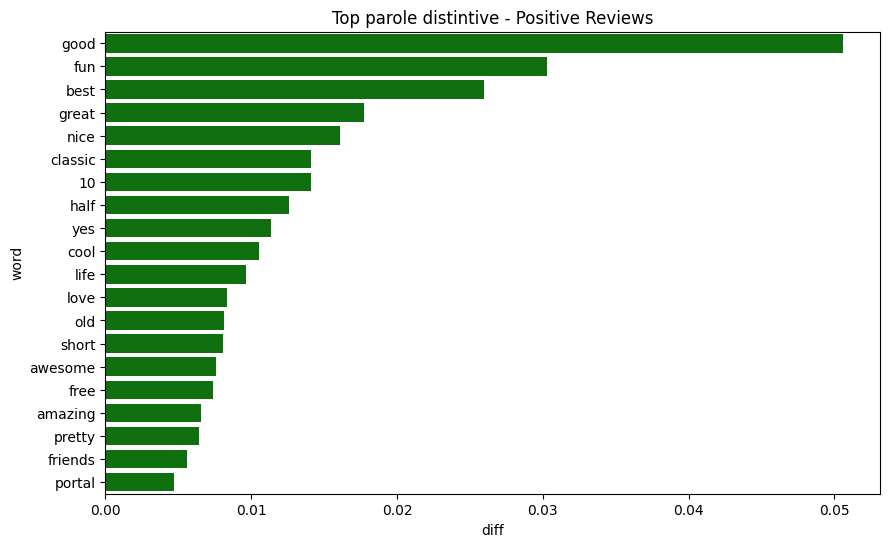

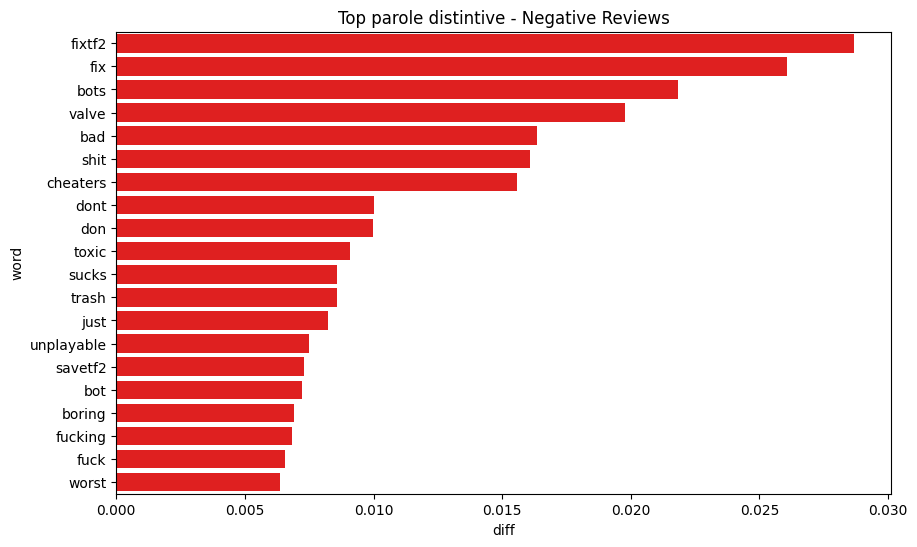

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

# Usa le recensioni "grezze" (lista di frasi), non i corpora concatenati
reviews_pos = corpus_split_pos
reviews_neg = corpus_split_neg

# Creiamo due etichette
all_reviews = reviews_pos + reviews_neg
labels = ["positive"] * len(reviews_pos) + ["negative"] * len(reviews_neg)

# TF-IDF vectorizer con stopwords
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(all_reviews)

# Media dei pesi per ciascun gruppo
import numpy as np
feature_names = vectorizer.get_feature_names_out()
avg_pos = X[np.array(labels) == "positive"].mean(axis=0).A1
avg_neg = X[np.array(labels) == "negative"].mean(axis=0).A1

df = pd.DataFrame({
    "word": feature_names,
    "pos": avg_pos,
    "neg": avg_neg
})
df["diff"] = df["pos"] - df["neg"]

# Top 20 positive
top_pos = df.sort_values("diff", ascending=False).head(20)

# Top 20 negative
top_neg = df.sort_values("diff", ascending=True).head(20)

# Plot positive
plt.figure(figsize=(10,6))
sns.barplot(x="diff", y="word", data=top_pos, color="green")
plt.title("Top parole distintive - Positive Reviews")
plt.show()

# Plot negative
plt.figure(figsize=(10,6))
sns.barplot(x=-top_neg["diff"], y=top_neg["word"], color="red")
plt.title("Top parole distintive - Negative Reviews")
plt.show()


In [27]:
# Helper function which concatenates all the data into a single corpus.

def concatenate_list_data(list):
    result= ''
    for element in list:
        result += str(element)
    return result

In [ ]:
corpus_pos = concatenate_list_data(corpus_split_pos)
corpus_neg = concatenate_list_data(corpus_split_neg)

In [ ]:
# Scarica le stopwords se necessario
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


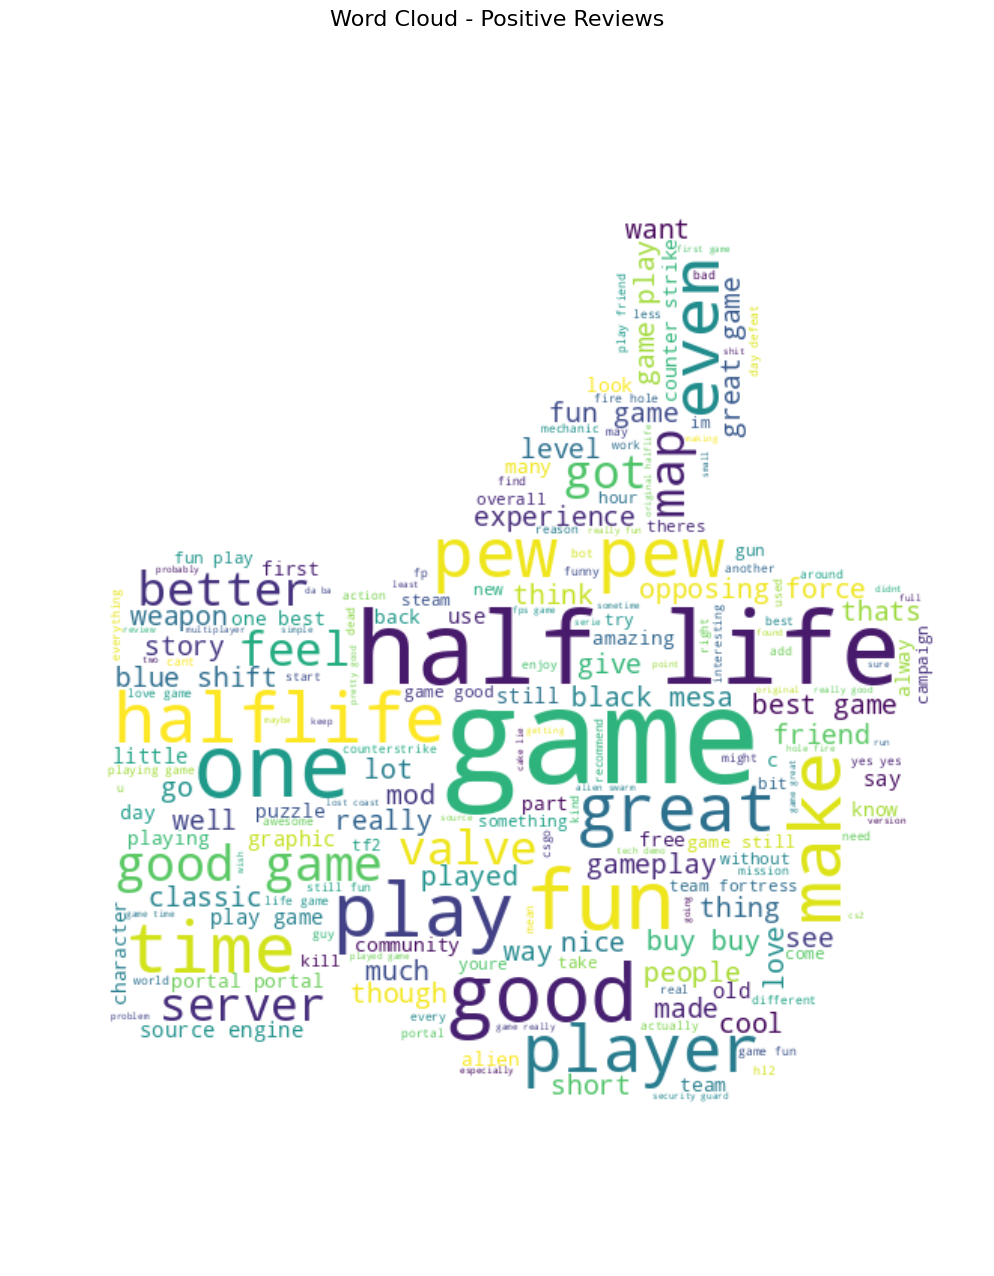

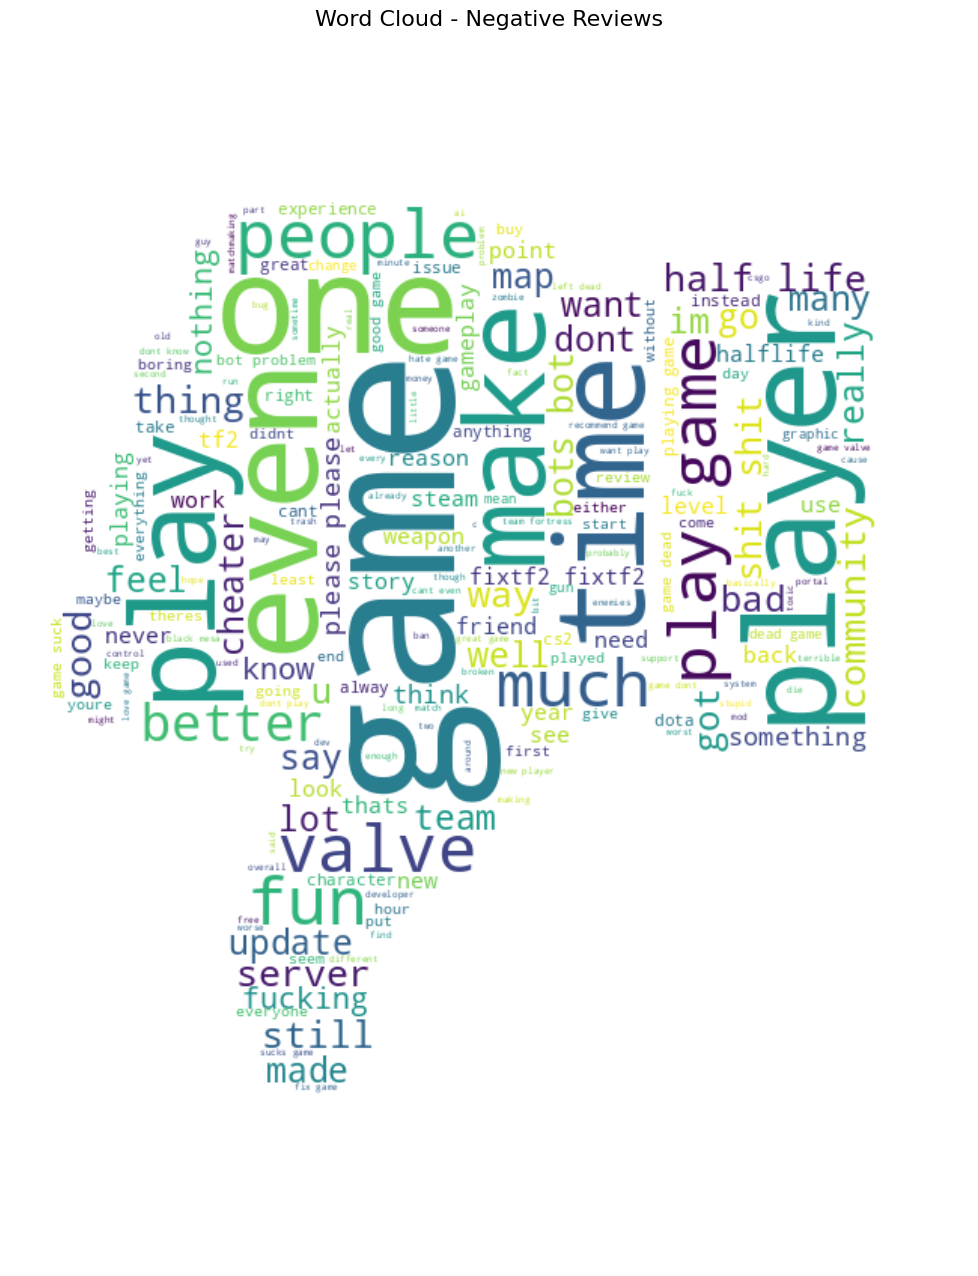

In [ ]:
def clean_text(text):
    text = text.lower()  # Converti tutto in minuscolo
    text = re.sub(r'[^\w\s]', '', text)  # Rimuove punteggiatura
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Rimuove stopwords
    return text

# Pulisci il corpus
corpus_pos_clean = clean_text(corpus_pos)
corpus_neg_clean = clean_text(corpus_neg)

# Carica le maschere (immagini in bianco e nero con le forme desiderate)
thumbs_up_mask = np.array(Image.open("thumbs up.jpg"))
thumbs_down_mask = np.array(Image.open("thumbs down.jpg"))

# Genera word cloud per recensioni positive
wordcloud_pos = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    mask=thumbs_up_mask,
).generate(corpus_pos_clean)

# Genera word cloud per recensioni negative
wordcloud_neg = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    mask=thumbs_down_mask,
).generate(corpus_neg_clean)

# Visualizza la word cloud per le recensioni positive
plt.figure(figsize=(16, 16))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud - Positive Reviews', fontsize=16)
plt.axis('off')
plt.show()

# Visualizza la word cloud per le recensioni negative
plt.figure(figsize=(16, 16))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud - Negative Reviews', fontsize=16)
plt.axis('off')
plt.show()
